This notebook trains a CNN to classify male vs female flies from a dorsal view.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from keras.models       import Sequential, load_model
from keras.layers       import Dense, Dropout, Activation, Flatten
from keras.layers       import Conv2D, MaxPooling2D
from keras.utils        import np_utils
from keras.optimizers   import Adam, Nadam
from keras.callbacks    import ModelCheckpoint, History

Using TensorFlow backend.


## Load Data

In [2]:
print('Loading...')
mdors = np.load('ndarrays/mdors227.npy')
fdors = np.load('ndarrays/fdors227.npy')
ishape= mdors[0].shape
print('Availible male samples:'  , len(mdors))
print('Availible female samples:', len(fdors))
print('Load Complete')

Loading...
Availible male samples: 1176
Availible female samples: 3934
Load Complete


## Preprocessing

First, to keep things simple I want an equal number of males and females

In [3]:
minlen = min(len(mdors), len(fdors))
mdors  = mdors[:minlen]
fdors  = fdors[:minlen]
flies  = np.concatenate((mdors, fdors))

Now I'll create their corresponding labels. Note, since we only have two classes we do not need to make binary matrices.

In [4]:
labels = np.zeros(len(flies))
labels[minlen:] += 1 # males == 0, females == 1

Shuffling the flies and labels together, now, will avoid repeating code later

In [5]:
i_shuffled = np.random.permutation(len(labels))
labels = labels[i_shuffled]
flies  = flies [i_shuffled]

If we take a peak at a few flies we can gather a little peace of mind--  the flies are correctly labeled.

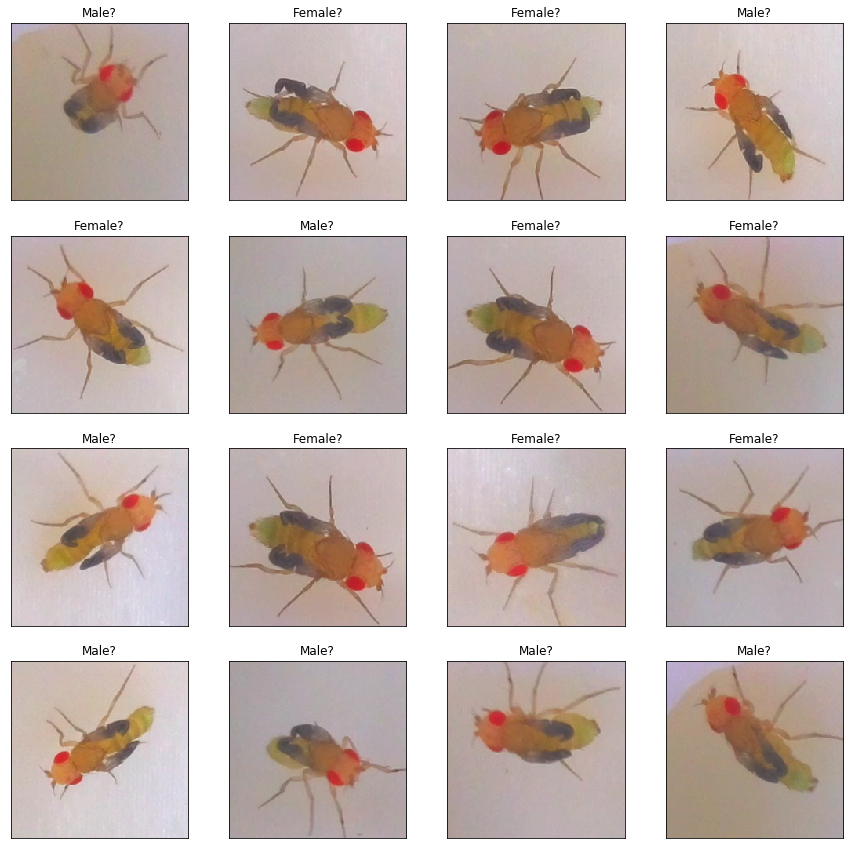

In [6]:
fig = plt.figure(figsize=(15,15))
titles = ['Male?', 'Female?']
for i, (label, fly) in enumerate(zip(labels[:16], flies[:16])):
    fig.add_subplot(4,4, i+1) 
    plt.imshow(fly)
    plt.title(titles[int(label)])
    plt.xticks([])
    plt.yticks([])

The males look male and the females look female, so let's split them into training, validation, and test sets.

## Normalization

In [7]:
flies  = flies.astype(np.float32)
flies /= 255

In [8]:
f_train = 0.8 # Let's train on 80% and validate/test on 10% each

## Split into training, validation, test, sets 

In [9]:
len_train = int(np.floor(len(flies) * f_train))
len_valid = (len(flies) - len_train) // 2
len_test  = len(flies) - len_train - len_valid
x_train = flies [:len_train]
y_train = labels[:len_train]
x_valid = flies [len_train: -len_test]
y_valid = labels[len_train: -len_test]
x_test  = flies [-len_test:]
y_test  = labels[-len_test:]
print('Training set samples  :', len(x_train), 'and labels:', len(y_train))
print('Validation set samples:', len(x_valid), ' and labels:', len(y_valid))
print('Test set samples      :', len(x_test) , ' and labels:', len(y_test))

Training set samples  : 1881 and labels: 1881
Validation set samples: 235  and labels: 235
Test set samples      : 236  and labels: 236


Check that the number of males and females in each set are roughly equal

In [10]:
print('Percent female in... ')
print('training set  : ' + str(y_train.sum() / len(y_train) * 100) + '%')
print('validation set: ' + str(y_valid.sum() / len(y_valid) * 100) + '%')
print('test set      : ' + str(y_test .sum() / len(y_test ) * 100) + '%')

Percent female in... 
training set  : 49.3886230728%
validation set: 52.3404255319%
test set      : 52.5423728814%


## Build Neural Net

In [11]:
w_init = 'glorot_normal' # Weights initialization
opt = Nadam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.01)
model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2), input_shape=ishape))
model.add(Conv2D( 8, (4, 4), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu', kernel_initializer=w_init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=w_init))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 8)       392       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
__________

## Train

In [12]:
best_model_path = 'trained_models/d_weights000.hdf5'
callbacks = [ModelCheckpoint(best_model_path)]
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=40, 
                    verbose=1, 
                    validation_data=(x_valid, y_valid), 
                    callbacks=callbacks)

Train on 1881 samples, validate on 235 samples
Epoch 1/40
1881/1881 [==============================] - 24s 13ms/step - loss: 0.6898 - acc: 0.5502 - val_loss: 0.6467 - val_acc: 0.6340
Epoch 2/40
1881/1881 [==============================] - 23s 12ms/step - loss: 0.4697 - acc: 0.7980 - val_loss: 0.7334 - val_acc: 0.5617
Epoch 3/40
1881/1881 [==============================] - 23s 12ms/step - loss: 0.3399 - acc: 0.8522 - val_loss: 0.2391 - val_acc: 0.9362
Epoch 4/40
1881/1881 [==============================] - 23s 12ms/step - loss: 0.2765 - acc: 0.8942 - val_loss: 0.1753 - val_acc: 0.9447
Epoch 5/40
1881/1881 [==============================] - 25s 13ms/step - loss: 0.1992 - acc: 0.9229 - val_loss: 0.1319 - val_acc: 0.9574
Epoch 6/40
1881/1881 [==============================] - 25s 13ms/step - loss: 0.1779 - acc: 0.9341 - val_loss: 0.1178 - val_acc: 0.9660
Epoch 7/40
1881/1881 [==============================] - 24s 13ms/step - loss: 0.1458 - acc: 0.9463 - val_loss: 0.1432 - val_acc: 0.9489
E

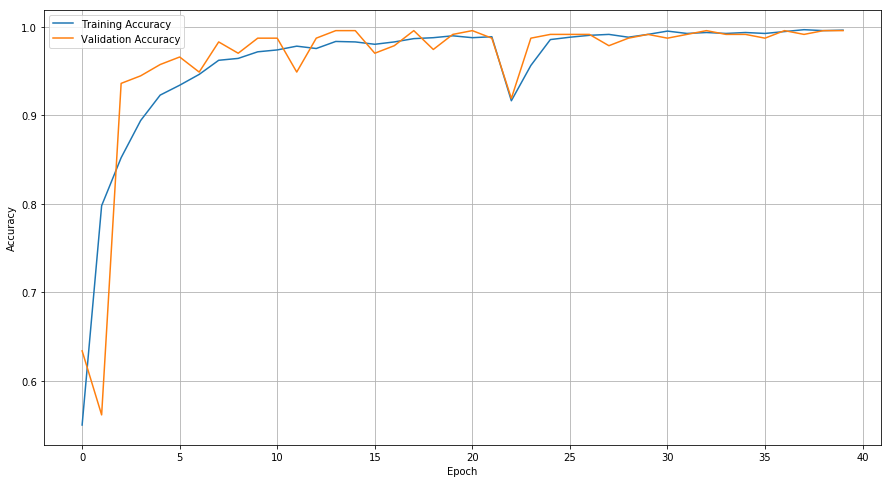

In [13]:
plt.figure(figsize=(15,8))
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

^Note the reason the validation accuracy is above the training accuracy is because the network has a dropout layer. The weights are only 'dropped out' in training, not in computing the validation (or test) accuracy.



## Load model with best validation accuracy and test!

In [14]:
model = load_model(best_model_path)

In [15]:
_, acc = model.evaluate(x_test, y_test)

236/236 [==============================] - 2s 8ms/step


In [16]:
print('Test accuracy: ' + str(acc*100) + '%')

Test accuracy: 99.1525423729%
